In [177]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import kmeans
import utils
import matplotlib
import gc
import correlation
import plotting
import read
import distance
import time
# pio.renderers.default = "vscode"
# pio.renderers.default = "browser"


def reload_utils():
    importlib.reload(utils)
    importlib.reload(kmeans)
    importlib.reload(correlation)
    importlib.reload(plotting)
    importlib.reload(read)
    importlib.reload(distance)

    return None


reload_utils()
gc.collect()

0

<!-- - timestep bug -->
- speed up sk vecs
- gmm
- lvc centering, fit
<!-- - pair correlation +1 -->
- kmeans weights
- analysis program
- plot rate
- plot sk
- vacf
- diffusion constant

- doe computational grad fellowshiop krell doe csgf
- doe one 

In [152]:
atomic_masses = {
    1: 196.966,  # Au
    2: 28.085,  # outer Si
    3: 28.085,  # center Si
    4: 15.999,  # O
    5: 1.008,  # outer H
    6: 12.011,  # C
    7: 1.008,  # center H
}

atoms = {1: "Au", 2: "Si", 3: "Si", 4: "O", 5: "H", 6: "C", 7: "H"}
train_path = "data/9-13/Au_trisiloxane_1000mols_eq500K.dump"
liquid_path = "data/9-13/Au_trisiloxane_1000mols_eq300K.dump"
droplet_path = "data/production_300K_50_a.dump"
base_path = "data/9-13/Au_trisiloxane_1000mols_eq"
train_path = r"C:\Users\gtdebru\phase\data\9-13\Au_trisiloxane_1000mols_eq500K.dump"

utils.print_memory(train_path)

file size: 5.244196497835219 GB
available memory: 13.41891860961914 GB


In [252]:
reload_utils()
df = read.process_data(
    train_path, atomic_masses, metal_type=1, Nt_lim=None, mode="ovito"
)
utils.getsize(df)
_ = gc.collect()


Reading Data...



100%|██████████| 501/501 [01:20<00:00,  6.25it/s]



Converting to molecule...Done
df_atom: 2.089 GB df_molecule: 0.021 GB Total: 2.11 GB


In [260]:
reload_utils()
v = utils.get_v(df)
vacf = correlation.calc_vacf0(v)

: 

In [256]:
reload_utils()
dt = 1e-12
# dt = 1
D = correlation.diffusion_constant(vacf[72:], dt)
print(D)

4.0682477052958656e-18


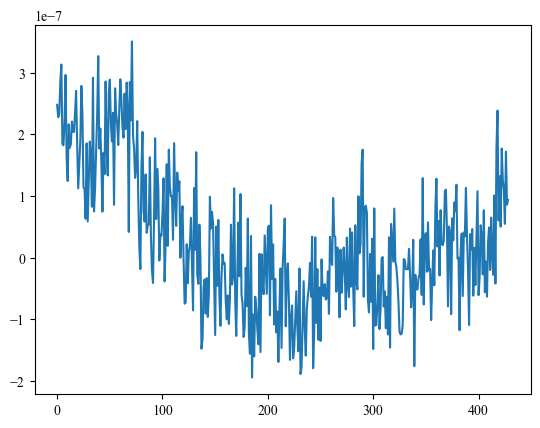

In [255]:
plt.plot(vacf[72:])


In [185]:
np.dot(v[0, 0], v[1, 0])

8.848346e-07

In [188]:
np.sum(v[0] * v[1], axis=1).shape

(1000,)

In [150]:
df["molecule"]["mass"].shape

(501, 1000)

In [ ]:
reload_utils()
lags = [i for i in range(6, 10, 2)]
radii = [i for i in range(14, 28, 2)]
utils.generate_dz(lags, df)
utils.generate_displacement(lags, df)
distance.generate_coord_num(radii, df)

Generating Coordination Number...<class 'numpy.ndarray'>
Done


In [83]:
d2[0].shape[0]

499500

In [79]:
d_unique = np.unique(distance[0].flatten())
d2_unique = np.unique(d2[0].flatten())
print(d_unique.shape, d2_unique.shape)

(492130,) (492129,)


In [86]:
np.sort(d_unique)[1:] - np.sort(d2_unique)

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [59]:
reload_utils()
plotting.plot_density(df, kind="molecule", absval=True, xlim=(15, 30))
plt.close()
# plt.show()

In [72]:
d2 = utils.distance(R, L, method="sparse")

In [76]:
reload_utils()
g, r = correlation.pair_correlation(d2, dr, L)


In [112]:
d2.shape

(501, 499500)

In [115]:
N = 1001
(N - 1) * N // 2

500500

In [120]:
500500 - 1

500499

In [121]:
df.keys()

dict_keys(['atom', 'molecule', 'bounds', 'reference_molecule_mask', 'Natom_per_molecule', 'metal_type', 'Ntypes', 'reference_molecule', 'dt', 'Nt', 'timesteps', 'Natom', 'Nmolecule', 'metal_molecule', 'metal_mask', 'non_metal', 'Nmetal', 'lower_surface', 'upper_surface', 'offset'])

In [103]:
reload_utils()
L = utils.get_L(df)
R = utils.get_pos(df)
distance = utils.distance(R, L, method="sparse")
dr = 2

In [107]:
reload_utils()
g, r = correlation.pair_correlation(distance, 1, L)

In [108]:
print(g.max(), g[1:].min())

8.648836423599915 1.651838914895837e-06


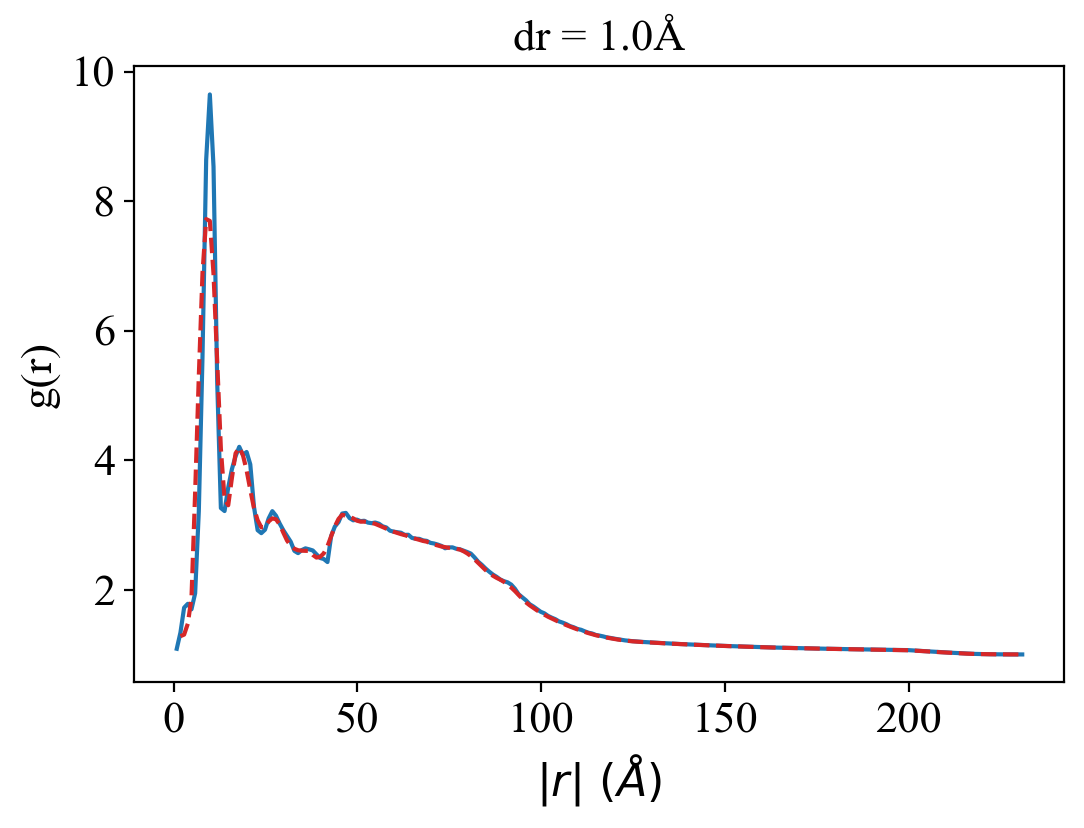

In [109]:
plotting.plot_pair_correlation(g, r)
plt.show()

In [23]:
reload_utils()
n = np.arange(1, 10)
n2 = np.arange(10, 100, 10)
n = np.concatenate((n, n2))
kvecs, kmags, kmask, start = correlation.sk_init(df, n)
r = utils.get_pos(df).T
mean_sk = correlation.sk_time_average(r, kvecs, kmask, start)

c:\Users\gtdebru\phase\correlate.py:112: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  sk = calc_sk(kvecs, r[:, :, t])


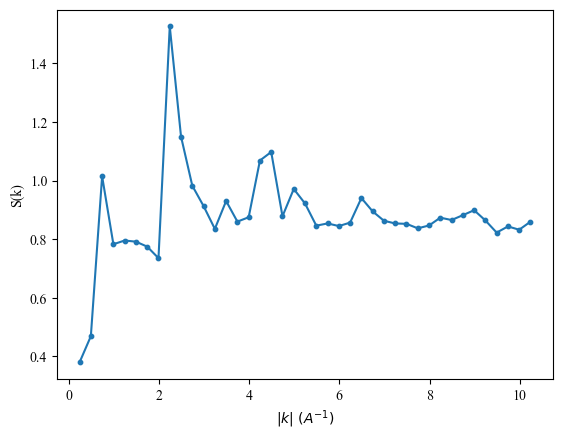

In [33]:
bin_centers, sk_bin = correlation.ssf_binned(df, n, mean_sk, dk=0.25)
fig, ax = plt.subplots()
ax.plot(bin_centers, sk_bin)
ax.scatter(bin_centers, sk_bin, s=10)
plt.xlabel(r"$|k| \ (A^{-1})$")
plt.ylabel("S(k)")
plt.show()

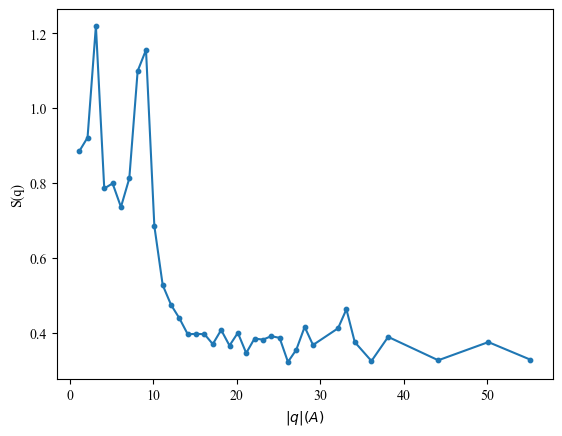

In [34]:
bin_centers, sk_bin = correlation.ssf_binned(df, n, mean_sk, dw=1)
fig, ax = plt.subplots()
ax.plot(bin_centers, sk_bin)
ax.scatter(bin_centers, sk_bin, s=10)
plt.xlabel(r"$ |q| (A)$")
plt.ylabel("S(q)")
plt.show()

In [35]:
reload_utils()
lag = 8
rad = 20
nstart = 10
seed = 0
tol = 1e-12
t = 80
# lag = 0
cluster_vars = [f"coordination_{rad}", "pe", f"log(dz_{lag})"]
cluster_vars = [f"log(displacement_{lag})"]
# cluster_vars = [f"coordination_26"]
df["cluster_vars"] = cluster_vars
molecule_phase, atom_phase, centroids, err = kmeans.classify_phase(
    df, cluster_vars, start=72
)

In [12]:
reload_utils()
metal_mask = df["metal_mask"]
pe_mol = np.sum(df["molecule"]["pe"], axis=1)
ke_mol = np.sum(df["molecule"]["ke"], axis=1)
pe_metal = np.sum(df["atom"]["pe"][:, metal_mask], axis=1)
ke_metal = np.sum(df["atom"]["ke"][:, metal_mask], axis=1)
E_total = pe_mol + ke_mol + pe_metal + ke_metal
E_mol = pe_mol + ke_mol

1.1607905060717119 500
1.2450648444046997 500
1.9943605464620597 500
-0.4378704963916473 500


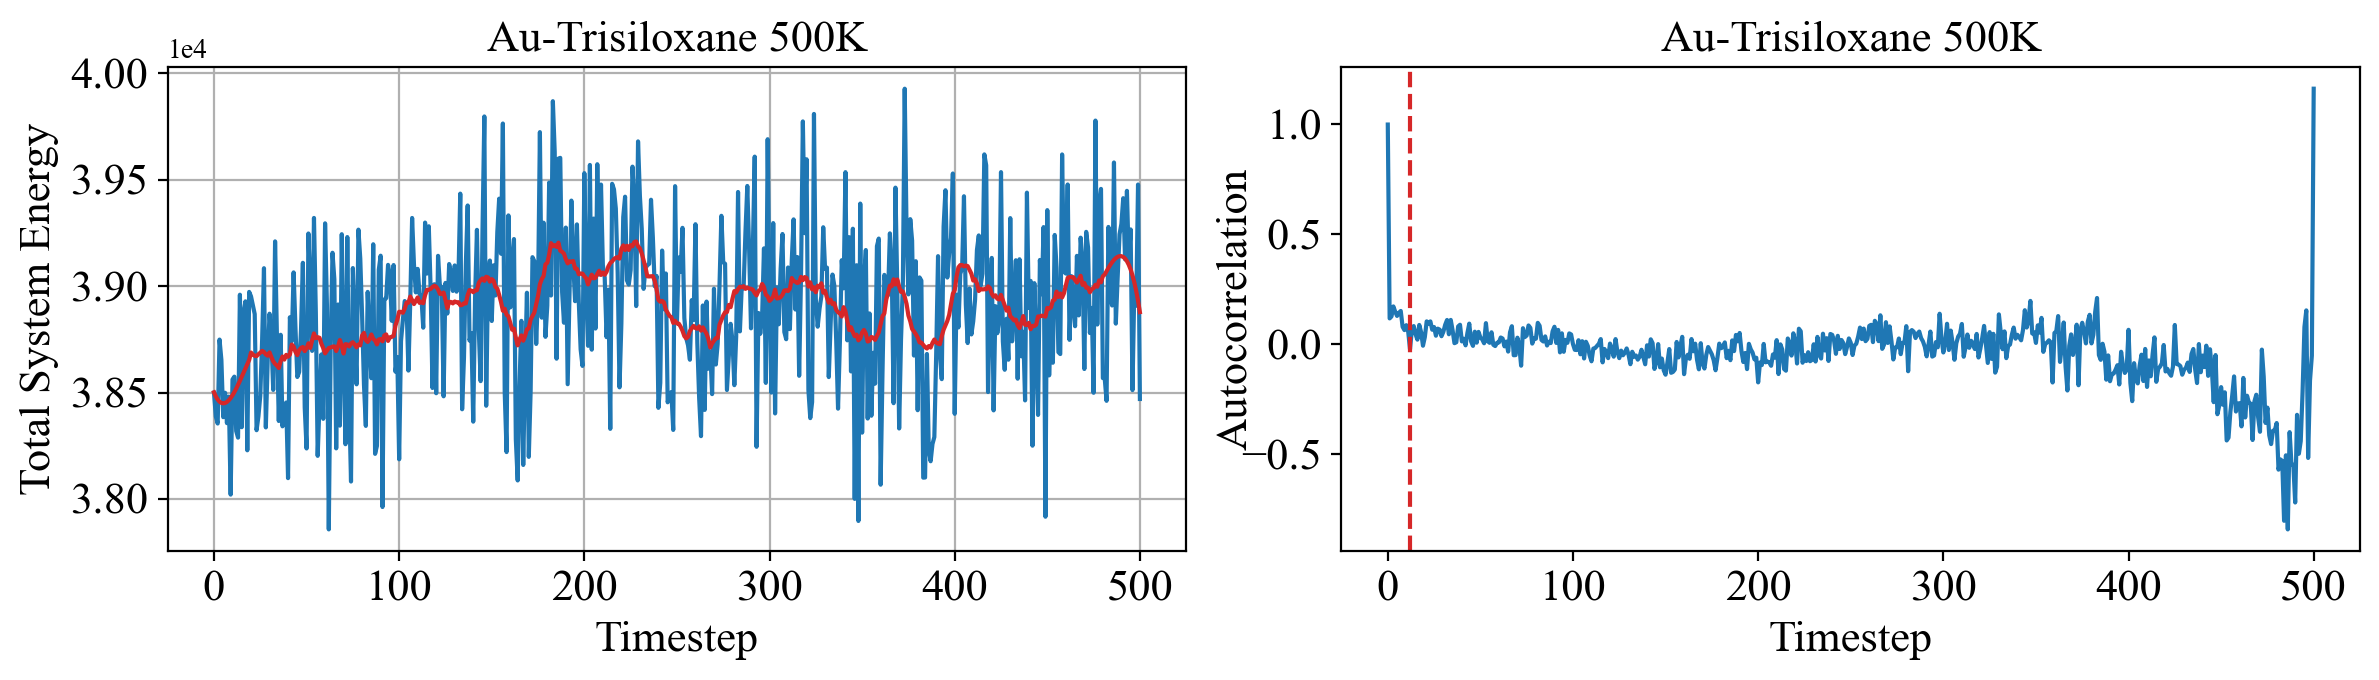

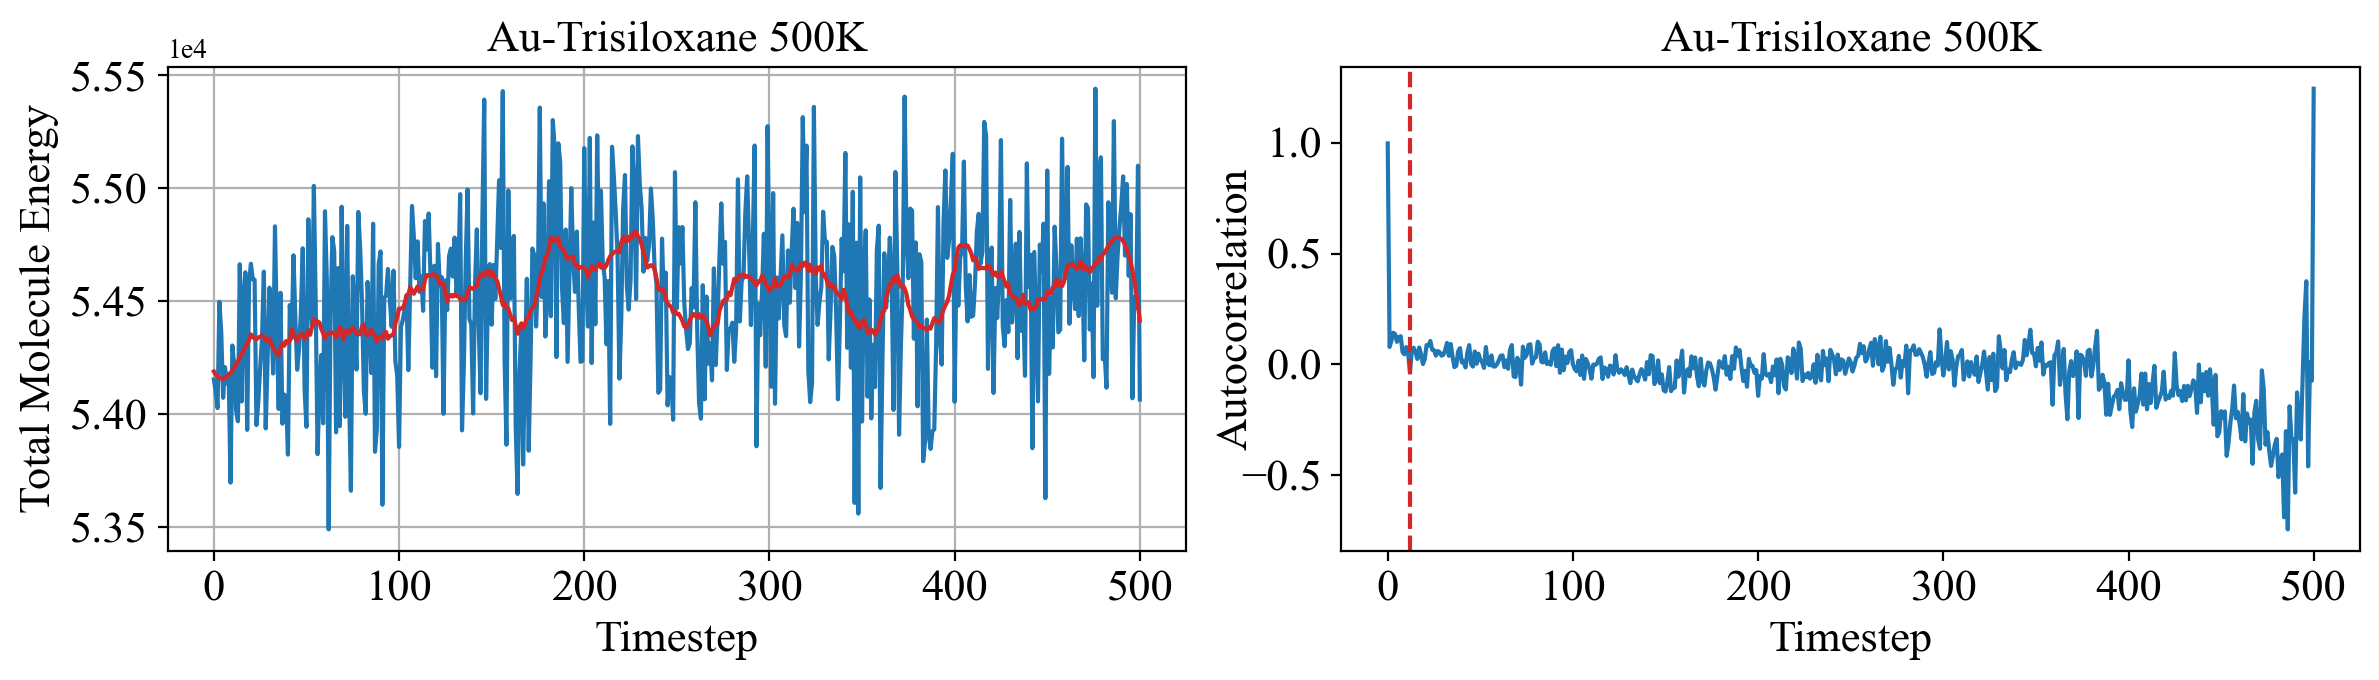

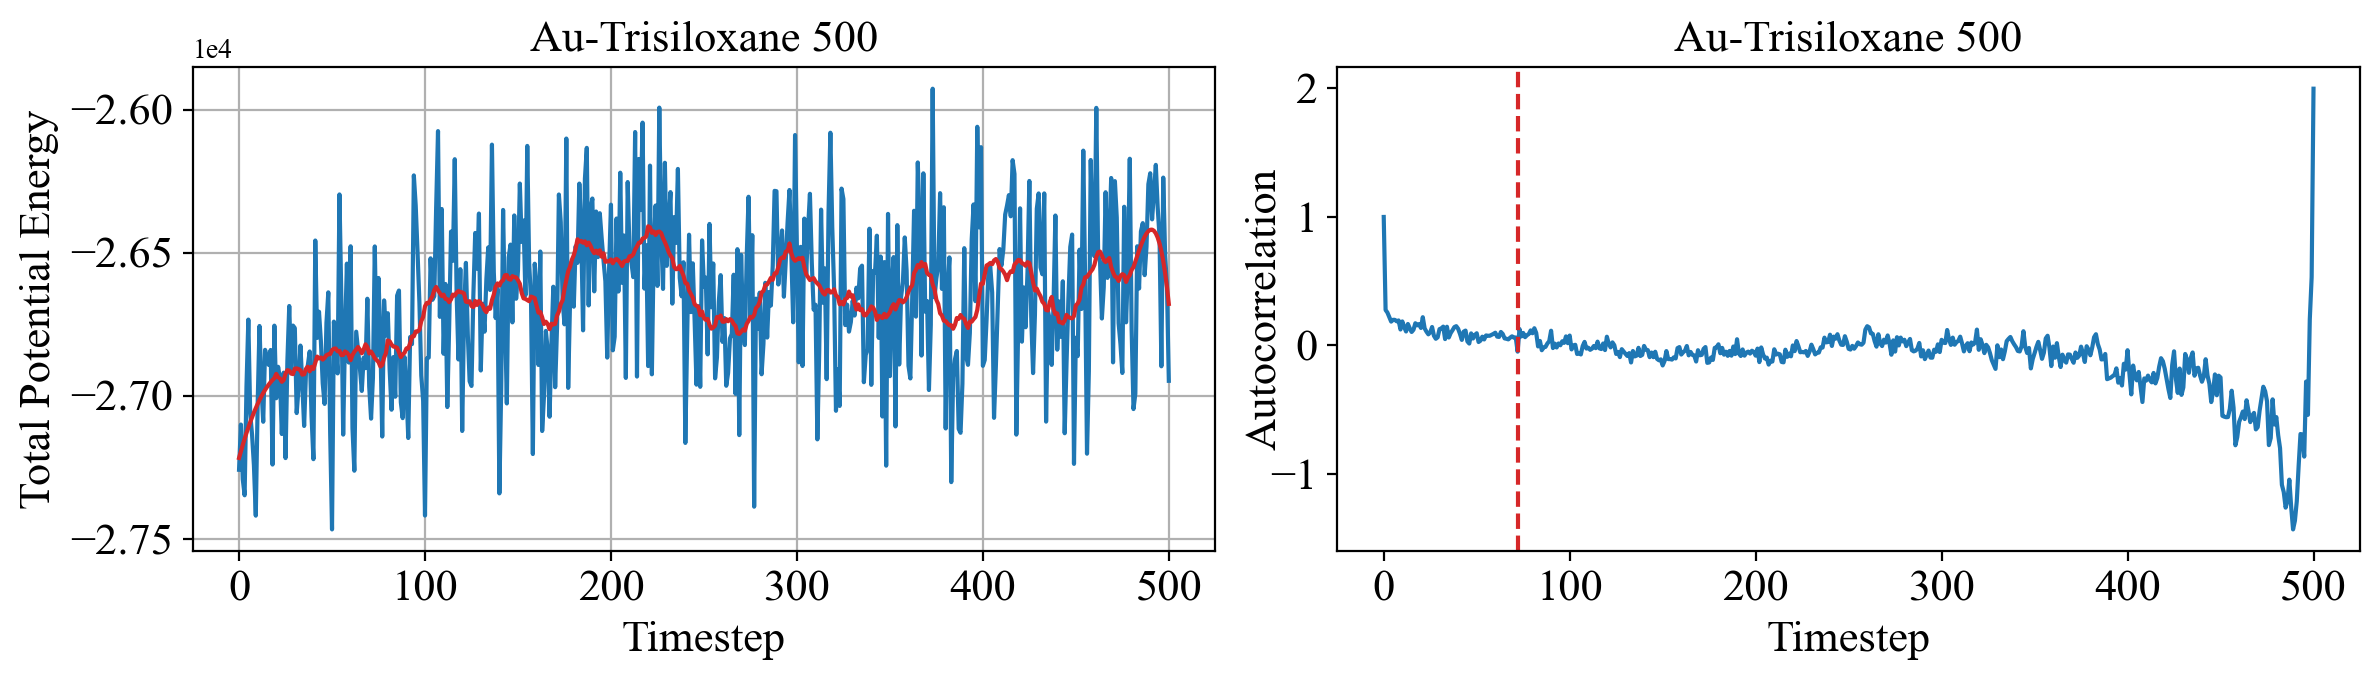

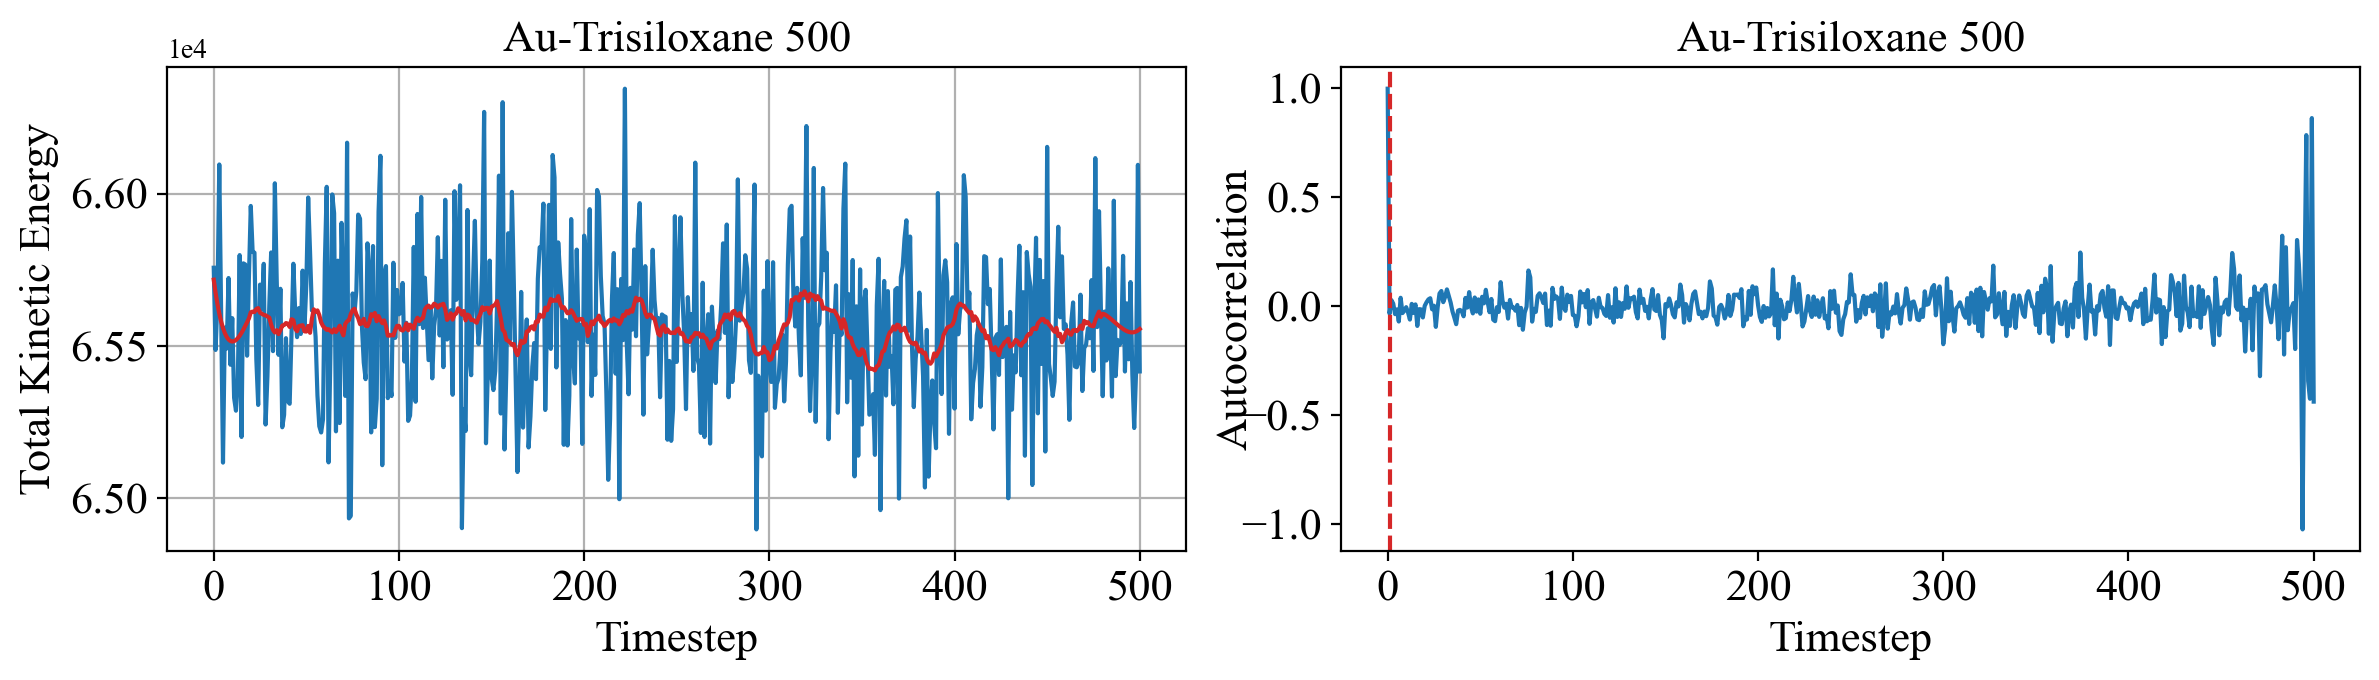

In [59]:
reload_utils()


fig1, ax1 = plotting.plot_energyac(
    E_total, ylabel="Total System Energy", title="Au-Trisiloxane 500K"
)
fig2, ax2 = plotting.plot_energyac(
    E_mol, ylabel="Total Molecule Energy", title="Au-Trisiloxane 500K"
)
fig3, ax3 = plotting.plot_energyac(
    pe_metal + pe_mol, ylabel="Total Potential Energy", title="Au-Trisiloxane 500"
)
fig4, ax4 = plotting.plot_energyac(
    ke_metal + ke_mol, ylabel="Total Kinetic Energy", title="Au-Trisiloxane 500"
)
# plt.close("all")
plt.show()

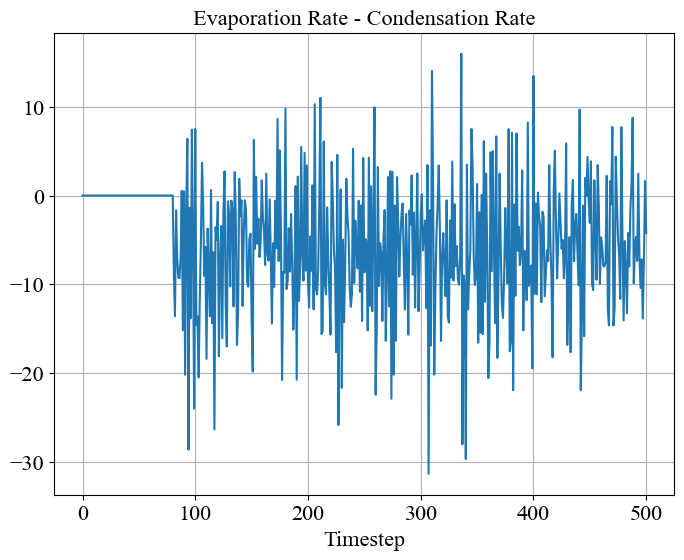

In [36]:
def plot_rate(df, ylabel="", title="", fs=16):
    rate_to_gas = df["molecule"]["rate_to_gas"]
    rate_to_liq = df["molecule"]["rate_to_liquid"]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(rate_to_gas - rate_to_liq)
    # ax.plot(rate_to_liq, label="Liquid")
    ax.set_xlabel("Timestep", fontsize=fs)
    ax.set_ylabel(ylabel, fontsize=fs)
    ax.set_title(title, fontsize=fs)
    # ax.legend(fontsize=fs)
    ax.grid()
    ax.tick_params(axis="both", which="major", labelsize=fs)

    plt.show()


plot_rate(df, title="Evaporation Rate - Condensation Rate")

In [ ]:
np.mean(df["molecule"]["rate_to_gas"]), np.mean(df["molecule"]["rate_to_liquid"])

In [ ]:
reload_utils()
utils.write_switch_info(df, "test.dump")

In [ ]:
reload_utils()
utils.scatter_var_step(
    df, "phase", 180, mode="mol", traces=True, ntraces=15, top=True, port=8080
)


In [ ]:
reload_utils()

fig = utils.scatter_var(df, "pe", 80, mode="mol", traces=False)
fig.show()

In [ ]:
reload_utils()

i = 0

fig = utils.plot_dist_app(df, "log(dz_24)", nbins=25, color_phase=True, norm=True)
fig.show()

In [ ]:
fig.write_image("newplot.png", scale=3)

pdms, faudi abdul jabad leigha (solidification, metals) university PA, mark osta berkeley (metals, atomistic), liz holm Michigan,  

femtosecond timescales, temp as a function of density, data graph from mac app store

In [ ]:
gas_to_liquid = df["molecule"]["gas_to_liquid"]
liquid_to_gas = df["molecule"]["liquid_to_gas"]
gas_liquid_ts = df["molecule"]["gas_liquid_ts"]
liquid_gas_ts = df["molecule"]["liquid_gas_ts"]
fig, axs = plt.subplots(ncols=1, figsize=(7, 5))
fs = 14
xlim = [10, 50]
nbins = 2000
# density = []
# for t in range(0, df["Nt"]):
#     metal_mask = df["atom"]["type"][t] != 1
#     lower_mask = df["atom"]["lower_mask"][t]

#     z = df["atom"]["z"][t].copy()
#     z[lower_mask & metal_mask] -= df["offset"]
#     z = z[metal_mask]
#     z = np.abs(z)
#     density.append(np.histogram(z, bins=nbins, range=(0, 200))[0])

# avg_density = np.mean(density, axis=0)

# ax = axs[0]
# ax.plot(np.arange(nbins) * 0.1, avg_density, label=r"$\rho$", color="black")
# ax.set_xlabel("Z (Å)", size=fs)
# ax.set_ylabel("Atom Count", size=fs)
# # ax.set_xlim(xlim)
# ax2 = ax.twinx()
# ax2.set_ylabel("t", size=fs)


# ax2.scatter(gas_to_liquid, gas_liquid_ts, color="tab:blue", s=2, label="gas to liquid")
# ax2.scatter(liquid_to_gas, liquid_gas_ts, color="tab:red", s=2, label="liquid to gas")

# ax2.vlines(
#     np.mean(gas_to_liquid),
#     0,
#     df["Nt"],
#     color="tab:blue",
#     linewidth=3,
#     zorder=10,
# )
# ax2.vlines(
#     np.mean(liquid_to_gas),
#     0,
#     df["Nt"],
#     color="tab:red",
#     linewidth=3,
#     zorder=10,
# )

# lines, labels = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# legend = ax2.legend(lines + lines2, labels + labels2, loc=0, prop={"size": 12})


# for handle in legend.legend_handles:
#     if isinstance(handle, matplotlib.collections.PathCollection):
#         handle.set_sizes([30])
#     elif isinstance(handle, matplotlib.lines.Line2D):
#         handle.set_linewidth(2.0)


density = []
for t in range(0, df["Nt"]):
    z = df["molecule"]["z"][t].copy()
    lower_mask = df["molecule"]["lower_mask"][t]
    z[lower_mask] -= df["offset"]
    z = np.abs(z)
    density.append(np.histogram(z, bins=nbins, range=(0, 200))[0])

avg_density = np.mean(density, axis=0)
# ax = axs[1]
ax = axs
ax.plot(np.arange(nbins) * 0.1, avg_density, label=r"$\rho$", color="black")
ax.set_xlabel("Z (Å)", size=fs)
ax.set_ylabel("Molecule Count", size=fs)
ax.set_xlim(xlim)

ax2 = ax.twinx()
ax2.set_ylabel("t", size=fs)
ax2.scatter(gas_to_liquid, gas_liquid_ts, color="tab:blue", s=2, label="gas to liquid")
ax2.vlines(
    np.mean(gas_to_liquid),
    0,
    df["Nt"],
    color="tab:blue",
    linewidth=3,
    zorder=10,
)
ax2.vlines(
    np.mean(liquid_to_gas),
    0,
    df["Nt"],
    color="tab:red",
    linewidth=3,
    zorder=10,
)

ax2.scatter(liquid_to_gas, liquid_gas_ts, color="tab:red", s=2, label="liquid to gas")
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
legend = ax2.legend(lines + lines2, labels + labels2, loc=0, prop={"size": 12})


for handle in legend.legend_handles:
    if isinstance(handle, matplotlib.collections.PathCollection):
        handle.set_sizes([30])
    elif isinstance(handle, matplotlib.lines.Line2D):
        handle.set_linewidth(2.0)

fig.suptitle(r"$Z_{transistion}$ for $coord_{26}$", fontsize=16)
fig.tight_layout()
plt.show()